Installing necessary packages

In [1]:
#!conda install -c anaconda xlrd --y

#!conda install -c conda-forge geocoder --yes

!conda install -c conda-forge folium=0.5.0 --yes


Solving environment: done

# All requested packages already installed.



Importing libraries to be used throughout the project

In [2]:
import pandas as pd
import numpy as np

#import geocoder
import folium #library to visualize maps


import requests # library to handle requests
from pandas.io.json import json_normalize # tranform JSON file into a pandas dataframe

# Matplotlib and associated plotting modules
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib.colors as colors

First, we import the data containing the latitude and longitude of the Montréal boroughs in the form of a csv file obtained in http://donnees.ville.montreal.qc.ca/ and clean it up a little.

In [3]:
df = pd.read_csv('lieux_d_interet.csv')

montreal_neigh = df[['Arrondissement','Latitude','Longitude']]

montreal_neigh = montreal_neigh.groupby('Arrondissement').mean()

montreal_neigh = montreal_neigh.reset_index()
montreal_neigh = montreal_neigh.rename(columns={"Arrondissement": "Neighborhood"})
montreal_neigh.head()

,Neighborhood,Latitude,Longitude
0,Ahuntsic-Cartierville,45.548620,-73.672374
1,Anjou,45.605264,-73.556336
2,Côte-des-Neiges–Notre-Dame-de-Grâce,45.484924,-73.629965
3,L'Île-Bizard–Sainte-Geneviève,45.489924,-73.876470
4,LaSalle,45.427733,-73.627594


We can take a look at Montréal and the location of each borough center

In [4]:
#Initializing Montréal map
montreal_map = folium.Map(location=[45.508888, -73.561668], zoom_start=12)

# add markers of boroughs centers to map
for lat, lng, borough in zip(montreal_neigh['Latitude'], montreal_neigh['Longitude'], montreal_neigh['Neighborhood']):
    label = '{}'.format( borough)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(montreal_map)  
    
montreal_map

Montréal has few and sparse boroughs, so we will have to search in a big area around each center. Next, let us define Foursquare cedentials to be used in the **Foursquare API**

In [73]:
#Defining Foursquare credentials
CLIENT_ID = 'PAQ5TNLWASWMWRVUIMWAG0OXGQF1K3XTW5TLJS3UMGCHT2UF' 
CLIENT_SECRET = '***' 
VERSION = '20180605' 

#Limit of entries to be searched
LIMIT = 5000

print('Your credentails:')
print('CLIENT_ID: ' + CLIENT_ID)
print('CLIENT_SECRET:' + CLIENT_SECRET)

Your credentails:
CLIENT_ID: PAQ5TNLWASWMWRVUIMWAG0OXGQF1K3XTW5TLJS3UMGCHT2UF
CLIENT_SECRET:***


Now we want to search for venues in entertainment categories around each borough center. 

In [6]:
#Function that search for nearby entertainment venues within 5000m radius from a given borough center to ensure every venue will be found
def getNearbyVenues(names, latitudes, longitudes, category, radius=4500):

    venues_list=[]
    
    if category == '4d4b7105d754a06378d81259': #stores category
        
        #refining for game stores, book stores and music stores        
        sub_categories = ['52f2ab2ebcbc57f1066b8b18','4bf58dd8d48988d122951735','56aa371be4b08b9a8d573554',
                          '4bf58dd8d48988d18d941735','4bf58dd8d48988d1fe941735','4bf58dd8d48988d1f3941735',
                          '4bf58dd8d48988d10b951735','4bf58dd8d48988d126951735','4bf58dd8d48988d114951735'] 
        
        for name, lat, lng in zip(names, latitudes, longitudes):
            print(name)
            
            # create the API request URL
            url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&categoryId={}&radius={}&limit={}'.format(
                CLIENT_ID, 
                CLIENT_SECRET, 
                VERSION, 
                lat, 
                lng,
                category,
                radius, 
                LIMIT)
            
            # make the GET request
            results = requests.get(url).json()["response"]['groups'][0]['items']
        
            # return only relevant information for each nearby venue
            venues_list.append([(
                name, 
                lat, 
                lng, 
                v['venue']['name'], 
                v['venue']['location']['lat'], 
                v['venue']['location']['lng'],  
                v['venue']['categories'][0]['name'],
                v['venue']['id']) for v in results if v['venue']['categories'][0]['id'] in sub_categories])

        nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
        nearby_venues.columns = ['Neighborhood', 
                      'Neighborhood Latitude', 
                      'Neighborhood Longitude', 
                      'Venue', 
                      'Venue Latitude', 
                      'Venue Longitude', 
                      'Venue Category',
                      'Venue ID']
            
        return(nearby_venues)
    
    else:
    
        for name, lat, lng in zip(names, latitudes, longitudes):
            #print(name)
            
            # create the API request URL
            url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&categoryId={}&radius={}&limit={}'.format(
                CLIENT_ID, 
                CLIENT_SECRET, 
                VERSION, 
                lat, 
                lng,
                category,
                radius, 
                LIMIT)
            
            # make the GET request
            results = requests.get(url).json()["response"]['groups'][0]['items']
        
            # return only relevant information for each nearby venue
            venues_list.append([(
                name, 
                lat, 
                lng, 
                v['venue']['name'], 
                v['venue']['location']['lat'], 
                v['venue']['location']['lng'],  
                v['venue']['categories'][0]['name'],
                v['venue']['id']) for v in results])

        nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
        nearby_venues.columns = ['Neighborhood', 
                      'Neighborhood Latitude', 
                      'Neighborhood Longitude', 
                      'Venue', 
                      'Venue Latitude', 
                      'Venue Longitude', 
                      'Venue Category',
                      'Venue ID']

        return(nearby_venues)

In [7]:
#The general entertainment and electronic entertainment venues categories id's were obtained in Foursquare documentation
entertainment_categories = ['4d4b7104d754a06370d81259','4d4b7105d754a06376d81259','4d4b7105d754a06377d81259','4d4b7105d754a06378d81259']

montreal_venues_list = []

#Running for each root entertainment category to search for venues
for cat in entertainment_categories:

    venues_category = getNearbyVenues(names = montreal_neigh['Neighborhood'],
                                       latitudes = montreal_neigh['Latitude'],
                                       longitudes = montreal_neigh['Longitude'],
                                       category = cat
                                      )
    montreal_venues_list.append(venues_category)

Ahuntsic-Cartierville
Anjou
Côte-des-Neiges–Notre-Dame-de-Grâce
L'Île-Bizard–Sainte-Geneviève
LaSalle
Lachine
Le Plateau-Mont-Royal
Le Sud-Ouest
Mercier–Hochelaga-Maisonneuve
Montréal-Nord
Outremont
Pierrefonds-Roxboro
Rivière-des-Prairies–Pointe-aux-Trembles
Rosemont–La Petite-Patrie
Saint-Laurent
Saint-Léonard
Verdun
Ville Mont-Royal
Ville de Westmount
Ville-Marie
Villeray–Saint-Michel–Parc-Extension


Great! Now we can merge all data into a single dataframe containing all the venues.

In [9]:
#Merging all dataframes from different root categories into one and droping all possible duplicates
montreal_venues = pd.concat(montreal_venues_list)

montreal_venues = montreal_venues.drop_duplicates(subset = 'Venue ID')

montreal_venues = montreal_venues.reset_index(drop = True)

In [10]:
#montreal_venues.to_csv('montreal_venues_new.csv')

In [11]:
montreal_venues

,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category,Venue ID
0,Ahuntsic-Cartierville,45.548620,-73.672374,Tango Social Club,45.537763,-73.626113,Arts & Entertainment,4e483352483b03d090f7d98d
1,Ahuntsic-Cartierville,45.548620,-73.672374,Maison des arts de Laval,45.558242,-73.716289,Concert Hall,4adb6372f964a520d42621e3
2,Ahuntsic-Cartierville,45.548620,-73.672374,Salle André-Mathieu,45.559711,-73.719335,Concert Hall,4adb63c3f964a520d92621e3
3,Ahuntsic-Cartierville,45.548620,-73.672374,Eastern Bloc,45.534372,-73.620008,Art Gallery,4ba4402bf964a520129038e3
4,Ahuntsic-Cartierville,45.548620,-73.672374,Studio Danse Montréal,45.534402,-73.619603,Dance Studio,4b7c9047f964a520419b2fe3
...,...,...,...,...,...,...,...,...
1170,Saint-Laurent,45.512492,-73.693559,Cellcom,45.496300,-73.655600,Electronics Store,4ed5a1f42fb63f69a6729561
1171,Saint-Léonard,45.585087,-73.593721,The Source,45.566453,-73.588585,Electronics Store,592f0501cf72a0064f962477
1172,Verdun,45.457736,-73.564435,librairie de verdun,45.457441,-73.567203,Bookstore,57f67ccc498e58edff56a4f3
1173,Ville-Marie,45.508690,-73.563545,Renaud-Bray,45.507489,-73.564558,Bookstore,4b5621d8f964a520df0128e3


So, we see that we found 1175 distinct entertainment venues. Now, let's see the unique categories found using Foursquare 

In [12]:
montreal_venues['Venue Category'].unique()

array(['Arts & Entertainment', 'Concert Hall', 'Art Gallery',
       'Dance Studio', 'Music Venue', 'Movie Theater',
       'Country Dance Club', 'Planetarium', 'Go Kart Track', 'Art Museum',
       'Museum', 'Comedy Club', 'Theater', 'Jazz Club', 'Multiplex',
       'Mini Golf', 'Performing Arts Venue', 'Circus', 'Roller Rink',
       'Outdoor Sculpture', 'Amphitheater', 'History Museum',
       'Science Museum', 'Indie Movie Theater', 'Public Art',
       'Opera House', 'Laser Tag', 'Rock Club', 'Disc Golf',
       'Indie Theater', 'Erotic Museum', 'Tour Provider', 'Lounge',
       'Wine Bar', 'Tapas Restaurant', 'Brewery', 'Bar',
       'Comfort Food Restaurant', 'Dive Bar', 'Pub', 'Pool Hall',
       'Beer Bar', 'Hookah Bar', 'Restaurant', 'Café', 'Strip Club',
       'Mexican Restaurant', 'Sports Bar', 'Gastropub', 'Pizza Place',
       'Hotel Bar', 'Deli / Bodega', 'Japanese Restaurant', 'Speakeasy',
       'Beer Garden', 'Spanish Restaurant', 'Cocktail Bar',
       'Italian Rest

We can still see a lot of categories non related to the project, like restaurants. So, our next step is to remove them.

In [13]:
#Removing categories not related to the project target  

rmv = [ 'Café', 'Gastropub', 'Pizza Place', 'Restaurant',
       'Italian Restaurant', 'Thai Restaurant', 'Steakhouse',
       'Vietnamese Restaurant', 'Caribbean Restaurant',
       'Hostel', 'Bistro', 'Multiplex', 'Diner', 'Hotel', 'Japanese Restaurant',
       'Tapas Restaurant', 'Middle Eastern Restaurant',
       'Korean Restaurant', 'Spanish Restaurant', 'Comfort Food Restaurant',
       'Greek Restaurant', 'Mediterranean Restaurant', 'Mexican Restaurant', 'Burger Joint',
       'Falafel Restaurant', 'French Restaurant', 'Asian Restaurant']

for category in rmv:
    ind = montreal_venues[montreal_venues['Venue Category'] == category].index
    montreal_venues.drop(ind, inplace = True)
    
montreal_venues = montreal_venues.reset_index(drop = True)    

In [14]:
montreal_venues.shape

(1095, 8)

In [15]:
montreal_venues['Venue Category'].unique()

array(['Arts & Entertainment', 'Concert Hall', 'Art Gallery',
       'Dance Studio', 'Music Venue', 'Movie Theater',
       'Country Dance Club', 'Planetarium', 'Go Kart Track', 'Art Museum',
       'Museum', 'Comedy Club', 'Theater', 'Jazz Club', 'Mini Golf',
       'Performing Arts Venue', 'Circus', 'Roller Rink',
       'Outdoor Sculpture', 'Amphitheater', 'History Museum',
       'Science Museum', 'Indie Movie Theater', 'Public Art',
       'Opera House', 'Laser Tag', 'Rock Club', 'Disc Golf',
       'Indie Theater', 'Erotic Museum', 'Tour Provider', 'Lounge',
       'Wine Bar', 'Brewery', 'Bar', 'Dive Bar', 'Pub', 'Pool Hall',
       'Beer Bar', 'Hookah Bar', 'Strip Club', 'Sports Bar', 'Hotel Bar',
       'Deli / Bodega', 'Speakeasy', 'Beer Garden', 'Cocktail Bar',
       'Nightclub', 'Gay Bar', 'Whisky Bar', 'Food Court',
       'Boat or Ferry', 'Irish Pub', 'Tea Room', 'Gaming Cafe',
       'Karaoke Bar', 'Bowling Alley', 'Event Space',
       'Belgian Restaurant', 'Park', 'Cli

Then, we are left with 1095 interest venues. Now we can create separate dataframes for electronic and gaming and non-electronic entertainment to ease our analysis  

In [16]:
electronic = [ 'Laser Tag', 'Karaoke Bar', 'Gaming Cafe', 'Recreation Center',
            'Electronics Store', 'Toy / Game Store', 'Video Store', 'Video Game Store', 'Music Store']

montreal_game = montreal_venues.loc[montreal_venues['Venue Category'].isin(electronic)]
montreal_rest = montreal_venues.loc[~montreal_venues['Venue Category'].isin(electronic)]

montreal_game = montreal_game.reset_index(drop = True)
montreal_rest = montreal_rest.reset_index(drop = True)

In [17]:
montreal_game.head()

,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category,Venue ID
0,Le Plateau-Mont-Royal,45.523375,-73.580624,Laser Quest,45.498344,-73.574511,Laser Tag,4ad4c06ef964a520e9fa20e3
1,Outremont,45.517682,-73.609762,Le Colonel Moutarde,45.523386,-73.581842,Gaming Cafe,560de70c498e45c0333c30b5
2,Outremont,45.517682,-73.609762,La P'tite Place,45.538315,-73.610858,Karaoke Bar,4c7717115cd6b1f734323e94
3,Rosemont–La Petite-Patrie,45.548560,-73.584090,Bar Zoe,45.559673,-73.597542,Karaoke Bar,4cd21ce53e63721ed8c5a7cc
4,Verdun,45.457736,-73.564435,Karaoke Bar Pang Pang,45.495280,-73.575920,Karaoke Bar,4b2db722f964a520c2da24e3


Let's visualize the number of electronic and gaming entertainment compared to other types of entertainment

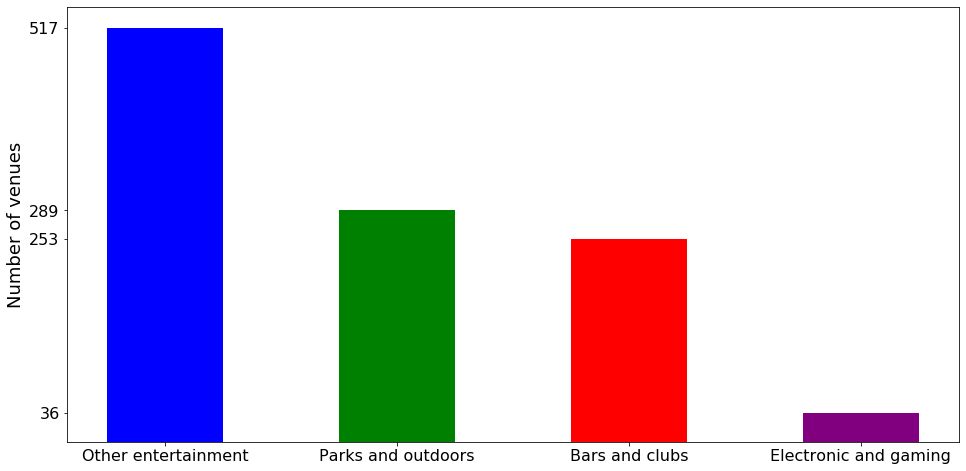

In [72]:
club = ['Comedy Club','Jazz Club','Country Dance Club', 'Rock Club', 'Lounge', 'Wine Bar', 'Brewery', 
        'Bar', 'Dive Bar', 'Pub',  'Beer Bar', 'Hookah Bar','Strip Club', 'Sports Bar',
        'Hotel Bar', 'Deli / Bodega', 'Speakeasy', 'Beer Garden','Cocktail Bar', 
        'Nightclub', 'Whisky Bar', 'Gay Bar', 'Tea Room', 'Sports Club']

park =  ['Park', 'Skate Park', 'Pool', 'Soccer Field', 'Garden', 'Trail', 'Baseball Field',
         'Nature Preserve', 'Mountain', 'Canal', 'Dog Run', 'Lake', 'Cycle Studio', 'Track', 'Harbor / Marina',
         'Rafting', 'Rock Climbing Spot', 'Botanical Garden', 'Outdoors & Recreation', 'Surf Spot', 'Beach']

montreal_rest_park = montreal_rest[montreal_rest['Venue Category'].isin(park)].shape[0]
montreal_rest_club = montreal_rest[montreal_rest['Venue Category'].isin(club)].shape[0]

size = [['Other entertainment', montreal_rest.shape[0]- (montreal_rest_park +montreal_rest_club)],['Parks and outdoors', montreal_rest_park],
        ['Bars and clubs', montreal_rest_club], ['Electronic and gaming', montreal_game.shape[0]]]

labels, ys = zip(*size)
xs = np.arange(len(labels)) 
width = 0.5

plt.figure(figsize=(16,8))
plt.bar(xs, ys, width, align='center', color=('blue','green','red','purple'))


plt.xticks(xs, labels) #Replace default x-ticks with xs, then replace xs with labels
plt.tick_params(labelsize=16)
plt.yticks(ys)
plt.ylabel('Number of venues', fontsize = 18)

plt.savefig('NumberofVenues.jpg')

We see that indeed the electronic and gaming categories of entertainment are much less represented in Montréal city, which may indicate a non saturated market.

Let us see how they are distributed in Montréal

In [30]:
montreal_map = folium.Map(location=[45.508888, -73.561668], zoom_start=12)

for lat, lng, neigh, venue in zip(montreal_game['Venue Latitude'], montreal_game['Venue Longitude'], montreal_game['Neighborhood'], montreal_game['Venue Category']):
    label = '{},{}'.format(venue,neigh)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='red',
        fill=True,
        fill_color='#d49d26',
        fill_opacity=0.7,
        parse_html=False).add_to(montreal_map)  
    
montreal_map

Let's see the number of venues in each of our target categories 

In [61]:
temp = montreal_game[['Venue','Venue Category']].groupby('Venue Category').count()
temp.rename(columns = {'Venue':'Number of Venues'}, inplace = True)
temp

,Number of Venues
Venue Category,
Electronics Store,16
Gaming Cafe,1
Karaoke Bar,5
Laser Tag,1
Recreation Center,6
Toy / Game Store,3
Video Game Store,1
Video Store,3


So, we see that there is only one Gaming Café, Laser Tag and Video Game store in Montréal. Therefore, let's focus on these categories now, as we want a business with a lowest competition. Also, although only one venue was listed as Video Game Store, we know that Electronics stores and Toy/Games stores might sell similar products. So we drop this from now, and focus on Gaming Café and Laser Tag

In [32]:
new_categories = ['Gaming Cafe', 'Laser Tag']

game_least = montreal_game[montreal_game['Venue Category'].isin(new_categories)]
game_least = game_least.reset_index(drop=True)

In [33]:
game_least

,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category,Venue ID
0,Le Plateau-Mont-Royal,45.523375,-73.580624,Laser Quest,45.498344,-73.574511,Laser Tag,4ad4c06ef964a520e9fa20e3
1,Outremont,45.517682,-73.609762,Le Colonel Moutarde,45.523386,-73.581842,Gaming Cafe,560de70c498e45c0333c30b5


Now, let us take a look at where this venues are located

In [42]:
montreal_map = folium.Map(location=[45.508888, -73.561668], zoom_start=12)

for lat, lng, neigh, venue in zip(game_least['Venue Latitude'], game_least['Venue Longitude'], game_least['Neighborhood'], game_least['Venue Category']):
    label = '{}, {}'.format(venue, neigh)
    label = folium.Popup(label, parse_html=True)
    folium.Marker(
        [lat, lng],
        popup=label).add_to(montreal_map) 

montreal_map

Let's explore the places further and check the rating of user for these two places

In [62]:
venue_id = game_least['Venue ID'].tolist()

for ids in venue_id:
    venue_id = ids # ID of venue
    url = 'https://api.foursquare.com/v2/venues/{}?client_id={}&client_secret={}&v={}'.format(venue_id, CLIENT_ID, CLIENT_SECRET, VERSION)
    result = requests.get(url).json()
    try:
        print('\n', result['response']['venue']['name'], 'has an average rating of',result['response']['venue']['rating'],'from',result['response']['venue']['ratingSignals'] , 'users. \n')
    except:
        print(result['response']['venue']['name'], 'has not been rated yet. \n')


 Laser Quest has an average rating of 7.5 from 48 users. 


 Le Colonel Moutarde has an average rating of 8.1 from 21 users. 



At this point, we can conclude that opening a new business similar to these two seems viable. If we want a business closer to the city center, *Centre Ville*, then a new Gaming Café could be a good choice. However, as it was rated by twice as many users, Laser Tag business seems to be also of higher demand. And its rating of 7.5 might indicate that a competitor offering better services would have great success.   